In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
import glob

In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)
wpod_net.summary()

Loading model successfully...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 448         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
______________________________________________________________

In [9]:
def preprocess_image(image_path,resize=False, resize_size = (224,224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    
    #print(img.shape)
    if resize:
        img = cv2.resize(img, resize_size, interpolation=cv2.INTER_NEAREST)
    return img

In [10]:
# Create a list of image paths 
#image_paths = glob.glob("../../TSK_00_MSC/wt2-body-tracker/det_car_originals/*.jpg")
image_paths = glob.glob("Plate_examples/*.jpg")
print("Found %i images..."%(len(image_paths)))

Found 18 images...


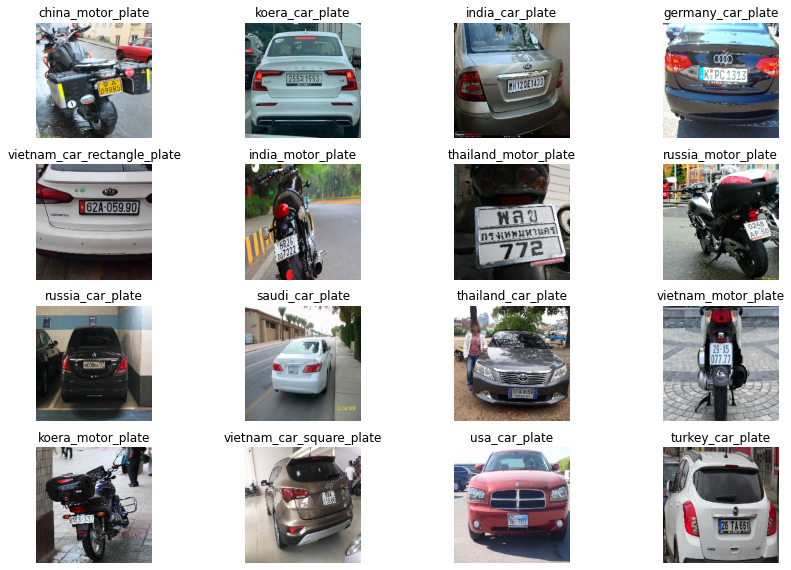

In [11]:
# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 4
rows = 4
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    #print(title)
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

Detect 1 plate(s) in india_car_plate
Coordinate of plate(s) in image: 
 [array([[362.36954918, 612.35992623, 611.38917973, 361.39880267],
       [308.69855296, 279.02888179, 343.71261945, 373.38229061],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


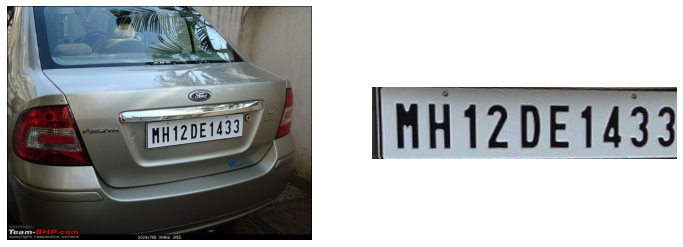

In [12]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=1200, resize = False, resize_size = (224,224)):
    vehicle = preprocess_image(image_path, resize= resize, resize_size = resize_size)
    #print(f'Vehicle shape : {vehicle.shape}')
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

# Obtain plate image and its coordinates from an image
test_image = image_paths[2]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))


vehicle, LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result

plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

#plt.savefig("part1_result.jpg",dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


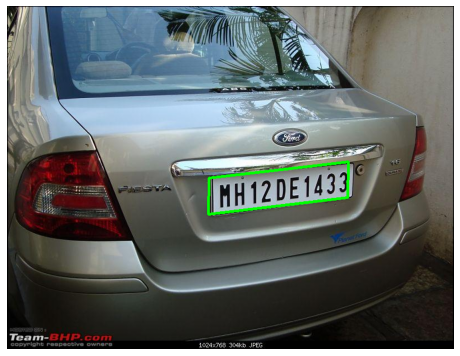

In [13]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

resize_size = (100,100)


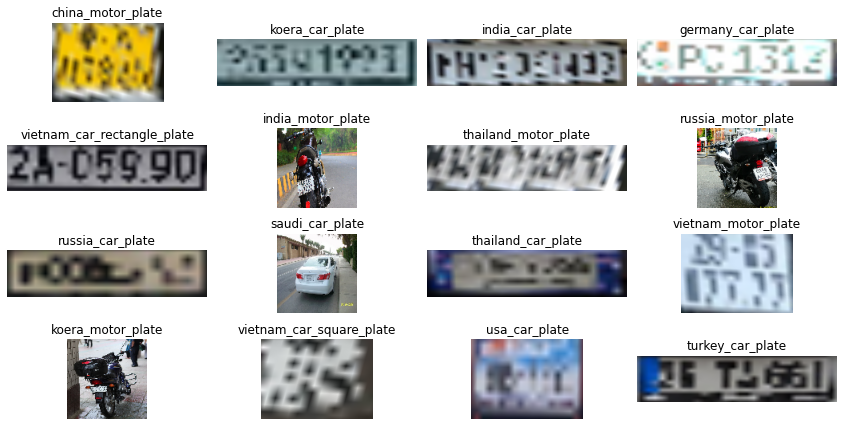

resize_size = (120,120)


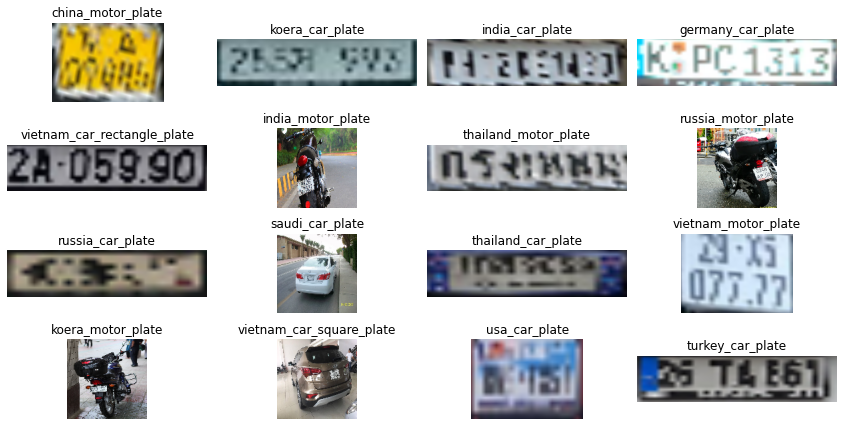

resize_size = (140,140)


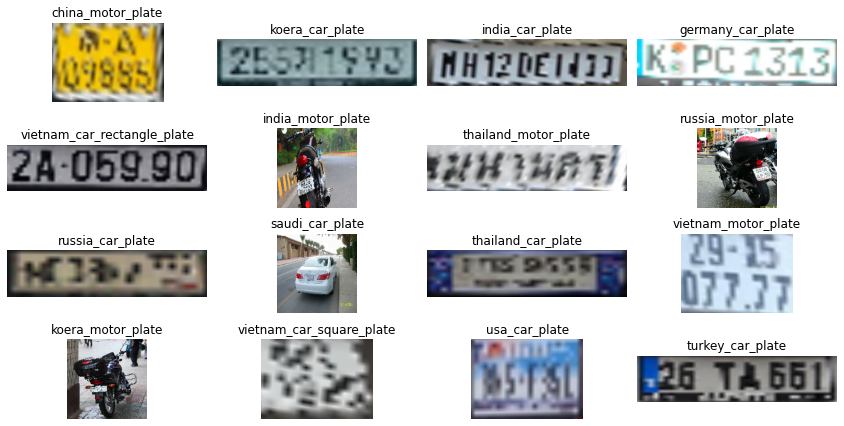

resize_size = (160,160)


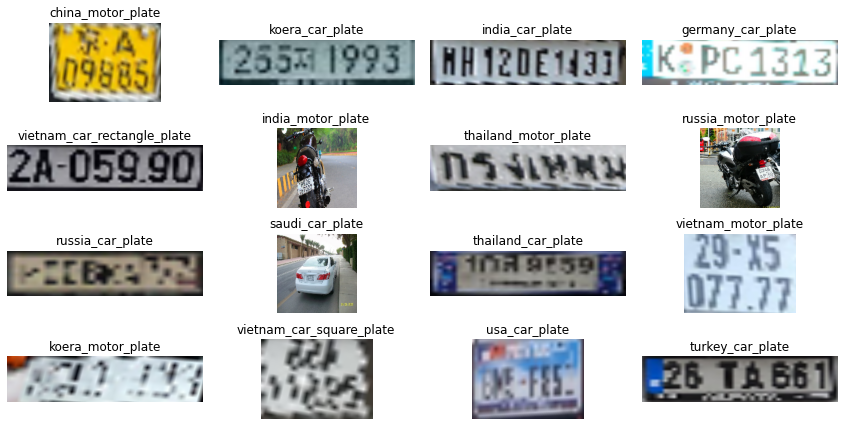

resize_size = (180,180)


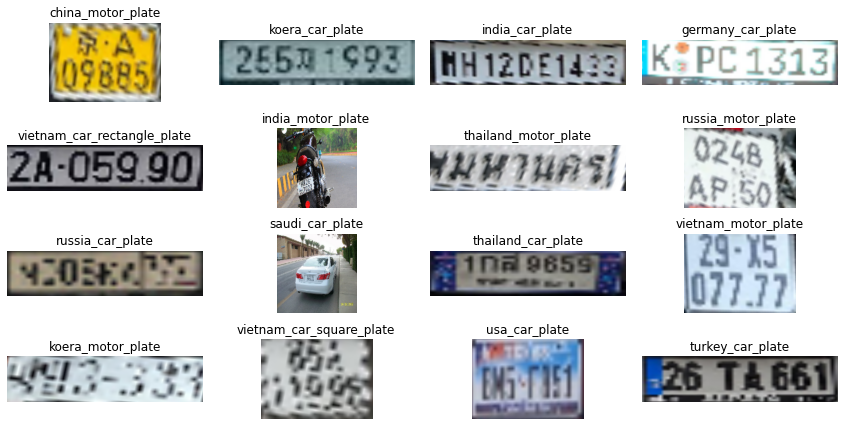

resize_size = (200,200)


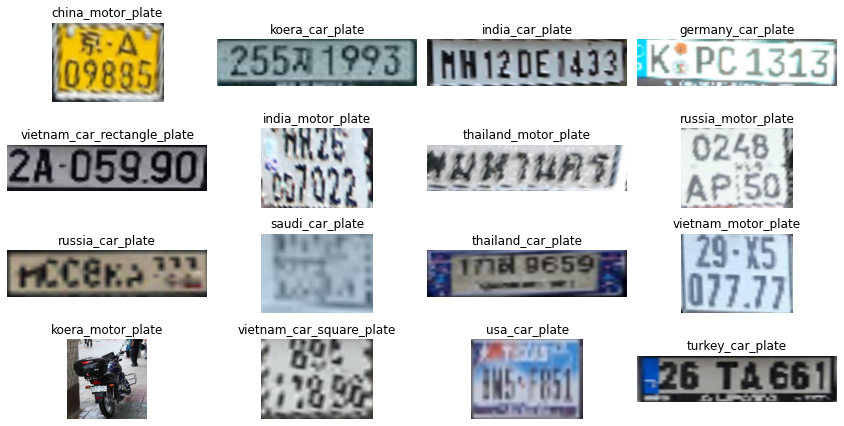

resize_size = (220,220)


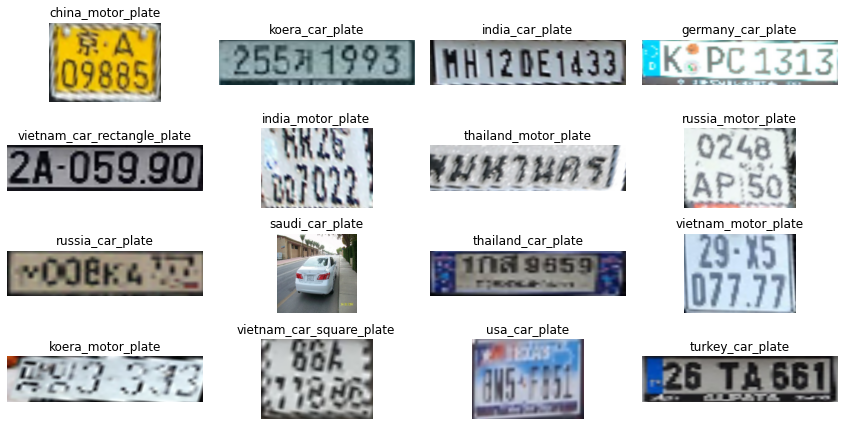

resize_size = (240,240)


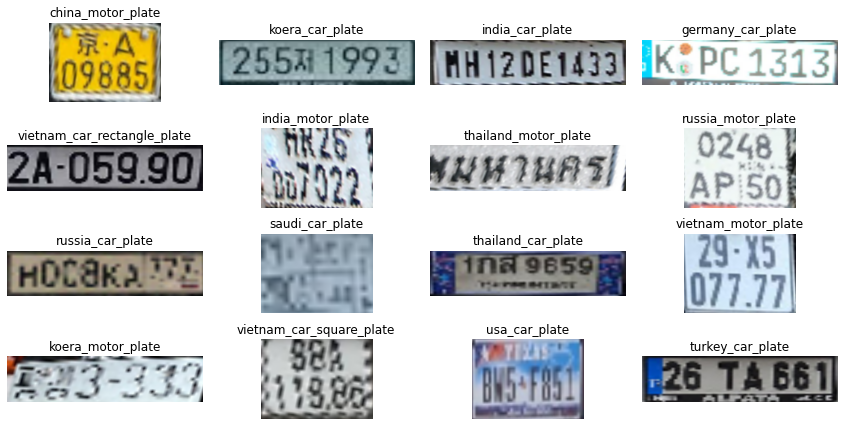

resize_size = (260,260)


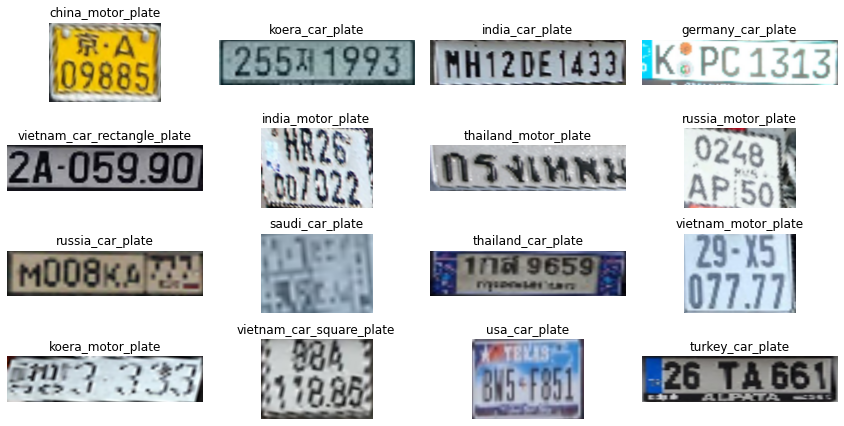

resize_size = (280,280)


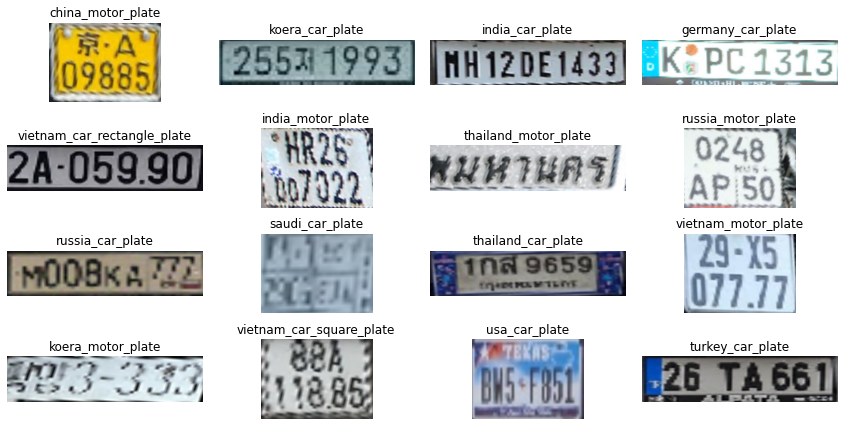

In [16]:
# Viualize all obtained plate images 


for figcnt, res in enumerate(range(100,300,20)):
    fig = plt.figure(num = figcnt, figsize=(12,6))
    cols = 4
    rows = 4
    fig_list = []
    print(f'resize_size = ({res},{res})')
    for i in range(cols*rows):
        fig_list.append(fig.add_subplot(rows,cols,i+1))
        title = splitext(basename(image_paths[i]))[0]
        fig_list[-1].set_title(title)
        vehicle, LpImg,_ = get_plate(image_paths[i], resize = True, resize_size = (res,res))
        plt.axis(False)
        if (LpImg != None):
            plt.imshow(LpImg[0])
        else:
            plt.imshow(vehicle)
    plt.tight_layout(True)
    plt.show()

## Bonus!

Detect 2 plate(s) in multiple_plates


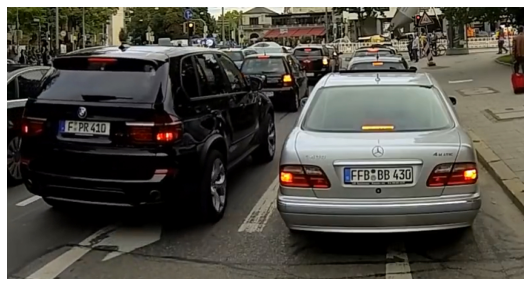

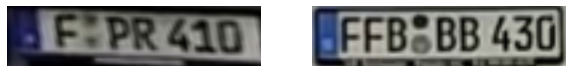

In [15]:
# Extract mutiple plate license in one image 

multiple_plates_image = "Plate_examples/multiple_plates.png"
vehicle, LpImg,cor = get_plate(multiple_plates_image)

print("Detect %i plate(s) in"%len(LpImg),splitext(basename(multiple_plates_image))[0])

# Visualize the original image
plt.figure(figsize=(10,5))
plt.axis(False)
plt.imshow(preprocess_image(multiple_plates_image))

# Visualize the obtained plates
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(LpImg[1])
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])



## The End!